In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 4.3MB/s 
     |████████████████████████████████| 901kB 48.8MB/s 
     |████████████████████████████████| 3.3MB 49.2MB/s 


In [ ]:
from google.colab import drive
import pandas as pd
from transformers import AutoTokenizer, AutoModel,AdamW,get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset,Dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**We** first split the data into a train and validation and test set. The test set will be used later to evaluate our model.

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Kaggle/stackoverflow/final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle/stackoverflow/final


In [ ]:
# df = pd.read_pickle("../big_dataset.pkl")
# df = df.reset_index(drop=True)
# train_dataset,test_dataset = train_test_split(df, test_size=0.01,stratify = df["is_answer"])
# train_dataset,val_dataset = train_test_split(train_dataset, test_size=0.015,stratify = train_dataset["is_answer"])
# print(f"length of train: {len(train_dataset)}, length of validation: {len(val_dataset)}, length of test: {len(test_dataset)}")
# del df #to reduce memory usage
# pd.to_pickle(train_dataset,"train_ds_big.pkl")
# pd.to_pickle(val_dataset,"val_ds_big.pkl")
# pd.to_pickle(test_dataset,"test_ds_big.pkl")

length of train: 1626900, length of validation: 24776, length of test: 16684


In [ ]:
train_dataset = pd.read_pickle("train_ds_big.pkl")
val_dataset = pd.read_pickle("val_ds_big.pkl")
test_dataset = pd.read_pickle("test_ds_big.pkl")
print(f"length of train: {len(train_dataset)}, length of validation: {len(val_dataset)}, length of test: {len(test_dataset)}")


length of train: 1618683, length of validation: 24651, length of test: 25026


**We**  select only the question pairs that have answers to train the model. <br>
We build two batches as input for the network and we assume that question $q_i$ (question $i$ in the first batch) is a answer of $a_i$ (answer $i$ in the second batch), but all other answers in the second batch are not answers of $q_i$.  
The test set uses the original pairs of questions and the status describing if the answers are answers.

In [ ]:
train_dataset = train_dataset[train_dataset["is_answer"]==1]
print(f"length of postive examples in train dataset: {len(train_dataset)}")
val_dataset = val_dataset[val_dataset["is_answer"]==1]
print(f"length of postive examples in validation dataset: {len(val_dataset)}")
test_dataset = test_dataset[test_dataset["is_answer"]==1]
print(f"length of postive examples in validation dataset: {len(test_dataset)}")

length of postive examples in train dataset: 809341
length of postive examples in validation dataset: 12326
length of postive examples in validation dataset: 12513


In [ ]:
class QADataset(Dataset):

    def __init__(self,df):
        
        self.ques_title = df["ques_title"].to_numpy()
        self.ques_body = df["ques_body"].to_numpy()
        self.ans = df["ans"].to_numpy()
        self.label = df["is_answer"].to_numpy()
        
        

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return { 
            "ques_title":self.ques_title[index],
            "ques_body":self.ques_body[index],
            "ans":self.ans[index],
            "label":self.label[index]
        }

    # we can call len(dataset) to return the size
    def __len__(self):
        return len(self.ans)

In [ ]:
model_name="distilbert-base-uncased"

In [ ]:
class BertEncoder(nn.Module):
    def __init__(self):
        super(BertOverflowEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)

        return pooled_output

class DPR(nn.Module):
    def __init__(self,question_encoder,answer_encoder):
          super(DPR, self).__init__()
          self.question_encoder = question_encoder
          self.answer_encoder = answer_encoder

    def forward(self, ques_ids, ques_mask, ans_ids, ans_mask):
        ques_encoding = self.question_encoder(input_ids=ques_ids, attention_mask=ques_mask)
        ans_encoding = self.answer_encoder(input_ids=ans_ids, attention_mask=ans_mask)

        return ques_encoding,ans_encoding

def negative_log_loss(q_vectors,ctx_vectors,loss_scale=None):
        """
        Computes nll loss for the given lists of question and ctx vectors.
        :return: a tuple of loss value and amount of correct predictions per batch
        """
        # q_vector: n1 x D, ctx_vectors: n2 x D, result n1 x n2
        
        scores = torch.matmul(q_vectors, torch.transpose(ctx_vectors, 0, 1))

        if len(q_vectors.size()) > 1:
            q_num = q_vectors.size(0)
            scores = scores.view(q_num, -1)

        softmax_scores = nn.functional.log_softmax(scores, dim=1)
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=device)

        loss = nn.functional.nll_loss(
            softmax_scores,
            labels,
            reduction="mean",
        )

        max_score, max_idxs = torch.max(softmax_scores, 1)
        correct_predictions_count = (max_idxs == labels).to(max_idxs.device).sum()

        if loss_scale:
            loss.mul_(loss_scale)

        return loss, correct_predictions_count.item()

In [ ]:
save_counter = 0
def save_best(model):
    torch.save(model.state_dict(), 'best_model_state_dot.bin')

def save_recent(model,history,best_loss):
    global save_counter
    print(f"Saved at {datetime.now().strftime('%H:%M:%S')}")
    context= {
        "history": history,
        "best_loss":best_loss
        }
    pd.to_pickle(context,"context_dot.pkl")
    torch.save(model.state_dict(), f'recent_model_state{save_counter}_dot.bin')
    save_counter = 1- save_counter

def load():
    context = pd.read_pickle("context_dot.pkl")
    best_state = torch.load('recent_model_state1_dot.bin');
    return best_state,context


In [ ]:
batch_size = 16
adam_eps =  1e-8
adam_betas =  (0.9, 0.999)
max_grad_norm =  1.0
small_batches_step = 100
big_batches_step = 200
weight_decay = 0.0
learning_rate =  1e-5

# Linear warmup over warmup_steps.
warmup_steps = 1200 #prev 1000

# Total number of training epochs to perform.
num_train_epochs=  4

#BERT
ques_max_length=256
ans_max_length= 256

In [ ]:
train_data_loader = DataLoader(QADataset(train_dataset),batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(QADataset(val_dataset),batch_size=batch_size)
test_data_loader = DataLoader(QADataset(test_dataset),batch_size=batch_size)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
ques_encoder_model = BertOverflowEncoder()
ans_encoder_model = BertOverflowEncoder()
model = DPR(ques_encoder_model,ans_encoder_model)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- T

DPR(
  (question_encoder): BertOverflowEncoder(
    (bert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dr

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=weight_decay, eps=adam_eps,betas=adam_betas)

total_steps = len(train_data_loader) * num_train_epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_steps
)

In [ ]:
history = defaultdict(list)
best_loss =1000

In [ ]:
# # load last state
# last_state, context = load()
# history,best_loss = context["history"],context["best_loss"]
# model.load_state_dict(last_state)

<All keys matched successfully>

In [ ]:
def eval_model( model, data_loader, loss_fn):
    losses = []
    accuracy = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            
            ques_title_batch, ques_body_batch, ans_batch = batch["ques_title"], batch['ques_body'], batch["ans"]      
            ques_encoding =tokenizer.__call__(
                ques_title_batch,
                text_pair = ques_body_batch,
                truncation=True,
                max_length=ques_max_length,
                padding='longest',
                return_tensors = 'pt'
            )  

            ans_encoding =tokenizer.__call__(
                ans_batch,
                truncation=True,
                max_length=ans_max_length,
                padding='longest',
                return_tensors = 'pt'
            )
            
            out1,out2 = model(
                    ques_encoding["input_ids"].to(device),
                    ques_encoding["attention_mask"].to(device),
                    ans_encoding["input_ids"].to(device),
                    ans_encoding["attention_mask"].to(device)
                )
            
            loss,correct_count = loss_fn(out1,out2)
            losses.append(loss.item())
            accuracy.append(correct_count/batch_size)

    model.train()
    return np.mean(losses), np.mean(accuracy)

In [ ]:
def train_epoch( model, data_loader, loss_fn, optimizer,scheduler,epoch):
    global best_loss
    model.train()
    losses = []
    accuracy = []

    for i, batch in enumerate(data_loader):
        #tokenize

        ques_title_batch, ques_body_batch, ans_batch = batch["ques_title"], batch['ques_body'], batch["ans"]      
        ques_encoding =tokenizer.__call__(
            ques_title_batch,
            text_pair = ques_body_batch,
            truncation=True,
            max_length=ques_max_length,
            padding='longest',
            return_tensors = 'pt'
        )  

        ans_encoding =tokenizer.__call__(
            ans_batch,
            truncation=True,
            max_length=ans_max_length,
            padding='longest',
            return_tensors = 'pt'
        )
        #forward
        out1,out2 = model(
                ques_encoding["input_ids"].to(device),
                ques_encoding["attention_mask"].to(device),
                ans_encoding["input_ids"].to(device),
                ans_encoding["attention_mask"].to(device)
            )

        optimizer.zero_grad()
        loss,correct_count = loss_fn(out1,out2)
        losses.append(loss.item())
        accuracy.append(correct_count/batch_size)
        history["batch_loss"].append(loss.item())
        history["batch_acc"].append(correct_count/batch_size)

        #backward
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

        #save
        if (i+1)%2000==0:
            save_recent(model,history,best_loss)
            l = np.mean(losses)
            acc =  np.mean(accuracy)
            print(f'Epoch [{epoch+1}/{num_train_epochs}], Step [{i+1}/{len(data_loader)}], Small Step Train Loss:{l:.4f}, Train Accuracy:{acc*100:.4f}%')
            print( "-" * 20)

        if (i+1)%10000==0 or i+1 == len(data_loader):
            l = np.mean(losses)
            acc =  np.mean(accuracy)
            val_loss,val_acc = eval_model(model,val_data_loader,loss_fn)

            history['train_loss'].append(l)
            history['train_acc'].append(acc)

            history['val_acc'].append(val_acc)
            history['val_loss'].append(val_loss)

            print(f'Epoch [{epoch+1}/{num_train_epochs}], Step [{i+1}/{len(data_loader)}], Big Step Train Loss:{l:.4f}, Validation Loss:{val_loss:.4f}')
            print(f'Epoch [{epoch+1}/{num_train_epochs}], Step [{i+1}/{len(data_loader)}], Big Step Train Accuracy:{acc*100:.4f}%, Validation Accuracy:{val_acc*100:.4f}%')
            print( "-" * 20)

            #save best model weight (based on validation)
            if val_loss < best_loss:
                save_best(model)
                best_loss = val_loss
            save_recent(model,history,best_loss)

    return np.mean(losses), np.mean(accuracy)

In [ ]:
for epoch in range(num_train_epochs):
    train_loss = train_epoch( model,train_data_loader,negative_log_loss, optimizer,scheduler, epoch)

Saved at 16:15:21
Epoch [1/4], Step [2000/50584], Small Step Train Loss:0.9915, Train Accuracy:77.8563%
--------------------
Saved at 16:29:23
Epoch [1/4], Step [4000/50584], Small Step Train Loss:0.6658, Train Accuracy:83.8172%
--------------------
Saved at 16:43:24
Epoch [1/4], Step [6000/50584], Small Step Train Loss:0.5426, Train Accuracy:86.1854%
--------------------
Saved at 16:57:26
Epoch [1/4], Step [8000/50584], Small Step Train Loss:0.4747, Train Accuracy:87.6281%
--------------------
Saved at 17:11:27
Epoch [1/4], Step [10000/50584], Small Step Train Loss:0.4305, Train Accuracy:88.6131%
--------------------
Epoch [1/4], Step [10000/50584], Big Step Train Loss:0.4305, Validation Loss:0.1969
Epoch [1/4], Step [10000/50584], Big Step Train Accuracy:88.6131%, Validation Accuracy:93.8959%
--------------------
Saved at 17:13:23
Saved at 17:27:25
Epoch [1/4], Step [12000/50584], Small Step Train Loss:0.3980, Train Accuracy:89.3687%
--------------------
Saved at 17:41:26
Epoch [1/4]

KeyboardInterrupt: ignored

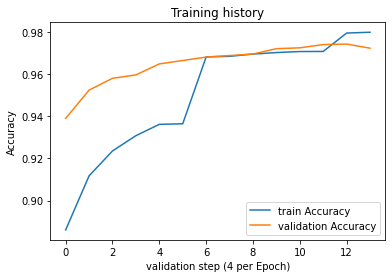

In [ ]:
plt.plot(history["train_acc"], label='train Accuracy')
plt.plot(history["val_acc"], label='validation Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('validation step (4 per Epoch)')
plt.legend()

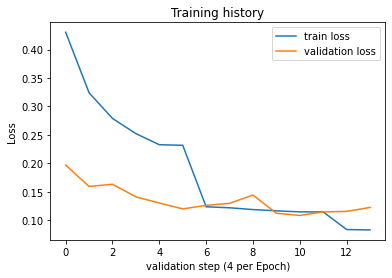

In [ ]:
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["val_loss"], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('validation step (4 per Epoch)')
plt.legend()

197216

In [ ]:
test_loss,test_acc =eval_model(model,test_data_loader,negative_log_loss)

In [ ]:
print(f"test Accuracy is {test_acc*100}%")

test Accuracy is 97.54150702426566%


In [ ]:
print(f"test Loss is {test_loss}")

test Loss is 0.11394203385568819


fasl

In [ ]:
test = test_dataset[:]

In [ ]:
test_encoding = np.empty((0,768))
ques_encoder_model.eval()
with torch.no_grad():
    for x in test.iterrows():
        ques_title,ques_body = x[1]["ques_title"],x[1]["ques_body"]
        ques_encoding =tokenizer.__call__(
            ques_title,
            text_pair = ques_body,
            truncation=True,
            max_length=ques_max_length,
            padding='longest',
            return_tensors = 'pt'
        )
        enc = ques_encoder_model( ques_encoding["input_ids"].to(device), ques_encoding["attention_mask"].to(device))
        test_encoding = np.vstack([test_encoding,enc.cpu()])
print(test_encoding.shape)
print(test_encoding)

(12513, 768)
[[ 0.21957041  0.05871633 -0.47717711 ... -0.02059981 -0.26361862
  -0.1701171 ]
 [ 0.07024603  0.3239693  -0.05192249 ...  0.15993565 -0.27529338
   0.27964827]
 [ 0.26350206  0.29723573  0.06827255 ...  0.05135059 -0.04910861
   0.10554145]
 ...
 [ 0.2703141   0.44326222 -0.34210336 ...  0.04567766  0.25472993
  -0.33304831]
 [ 0.18905362  0.01253811 -0.2969546  ... -0.04815906  0.00241213
  -0.20985492]
 [ 0.13487095 -0.02454663 -0.46219724 ... -0.55548501  0.18564965
  -0.09016064]]


In [ ]:
ans_encoding = np.empty((0,768))
ans_encoder_model.eval()
with torch.no_grad():
    for i,x in enumerate( test_dataset["ans"]):
            
        ans_enc =tokenizer.__call__(
            x,
            truncation=True,
            max_length=ans_max_length,
            padding='longest',
            return_tensors = 'pt'
        )
        ans_enc = ans_encoder_model( ans_enc["input_ids"].to(device), ans_enc["attention_mask"].to(device))
        ans_encoding = np.vstack([ans_encoding,ans_enc.cpu()])

In [ ]:
print("number of questions",len(test_encoding))
print("number of answers available",len(ans_encoding))

number of questions 12513
number of answers available 12513


In [ ]:
def eval_top_k(test_encoding,ans_encoding,k):
    similarity = np.dot(test_encoding,ans_encoding.T)
    pred = np.argpartition(-similarity, k)[:,:k]
    cnt =0 
    for i,row in enumerate(pred):
        if i in row:
            cnt+=1
    return cnt/len(test_encoding)*100

In [ ]:
k=1
print(f"percantage of exact matches: {eval_top_k(test_encoding,ans_encoding,k):.2f}%")

percantage of exact matches: 53.84%


In [ ]:
k=5
print(f"percantage of Top-5 retrieved answers matches: {eval_top_k(test_encoding,ans_encoding,k):.2f}%")

percantage of Top-5 retrieved answers matches: 73.36%


In [ ]:
k=10
print(f"percantage of Top-10 retrieved answers matches: {eval_top_k(test_encoding,ans_encoding,k):.2f}%")

percantage of Top-10 retrieved answers matches: 79.83%


In [ ]:
k=100
print(f"percantage of Top-100 retrieved answers matches: {eval_top_k(test_encoding,ans_encoding,k):.2f}%")

percantage of Top-100 retrieved answers matches: 94.57%
